In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define constants
DATA_DIR = "train_image"
LABELS_FILE = "train.csv"
IMG_SIZE = (256, 256)  # Keep 256x256 image size
BATCH_SIZE = 32

# Load labels
df = pd.read_csv(LABELS_FILE)
df["file_path"] = df["Id"].apply(lambda x: os.path.join(DATA_DIR, f"{x}.jpg"))

# Function to load and preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)  # Resize to 256x256
    img_array = img_to_array(img).astype("float32")  # Convert to float32
    return img_array

# Load images
X = np.array([preprocess_image(img_path) for img_path in df["file_path"]])
y = df["Pawpularity"].values

# Standardize images (Z-score normalization like CIFAR-10)
mean = np.mean(X, axis=(0,1,2,3))
std = np.std(X, axis=(0,1,2,3))
X = (X - mean) / (std + 1e-7)

# Shuffle and split dataset into 70% Train, 15% Validation, 15% Test
indices = np.random.permutation(len(X))
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

print(f"Train dataset: {len(X_train)} samples")
print(f"Validation dataset: {len(X_val)} samples")
print(f"Test dataset: {len(X_test)} samples")

Train dataset: 6938 samples
Validation dataset: 1486 samples
Test dataset: 1488 samples


# Model 0: Baseline

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_train_flat = X_train.reshape(len(X_train), -1)  # Flatten images
X_test_flat = X_test.reshape(len(X_test), -1)

linreg = LinearRegression()
linreg.fit(X_train_flat, y_train)
y_pred = linreg.predict(X_test_flat)

mse_baseline = mean_squared_error(y_test, y_pred)
mae_baseline = mean_absolute_error(y_test, y_pred)

print(f"Baseline Model MSE: {mse_baseline:.4f}")
print(f"Baseline Model MAE: {mae_baseline:.4f}")

Baseline Model MSE: 482.0162
Baseline Model MAE: 16.4661


# Model 1

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model1
model1 = keras.Sequential()

# Input Layer
model1.add(layers.Input(shape=(256, 256, 3)))  # Keep 256x256 image size

# First Convolutional Block
model1.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model1.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model1.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.4))  # Prevent overfitting
model1.add(layers.Dense(1, activation='linear'))  # Regression output

# Compile the model1 with Mean Squared Error (MSE) loss
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Show the model1 architecture
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,074,033 (4.10 MB)

 Trainable params: 1,073,809 (4.10 MB)

 Non-trainable params: 224 (896.00 B)

In [8]:
import time

# Callback to display loss at each epoch
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        t = time.monotonic() - self.time
        print('| Epoch {:2} | Time {:6.2f}s | Train Loss {:.4f} | Val Loss {:.4f} |'
              .format(epoch, t, logs['loss'], logs['val_loss']))

    def on_epoch_begin(self, epoch, logs):
        if epoch == 0:
            self.time = time.monotonic()

# Define training parameters
EPOCHS = 50
BATCH_SIZE = 32

# Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model1
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, PrintLoss()]
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 628.8413 - mae: 18.7850| Epoch  0 | Time 252.74s | Train Loss 571.0066 | Val Loss 655.2336 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - loss: 628.5760 - mae: 18.7812 - val_loss: 655.2336 - val_mae: 18.2449
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 493.3467 - mae: 16.4649| Epoch  1 | Time 516.63s | Train Loss 489.9073 | Val Loss 470.2359 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - loss: 493.3310 - mae: 16.4654 - val_loss: 470.2359 - val_mae: 16.3736
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 463.6934 - mae: 16.2001| Epoch  2 | Time 779.28s | Train Loss 455.3457 | Val Loss 489.8622 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - loss: 463.6551 - mae: 16.1994 - val_loss: 489.8622 - val_mae: 17.2114
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 405.4204 - mae: 15.2040| Epoch  3 | Time 1047.95s | Train Loss 398.4048 | Val Loss 470.6703 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - loss:

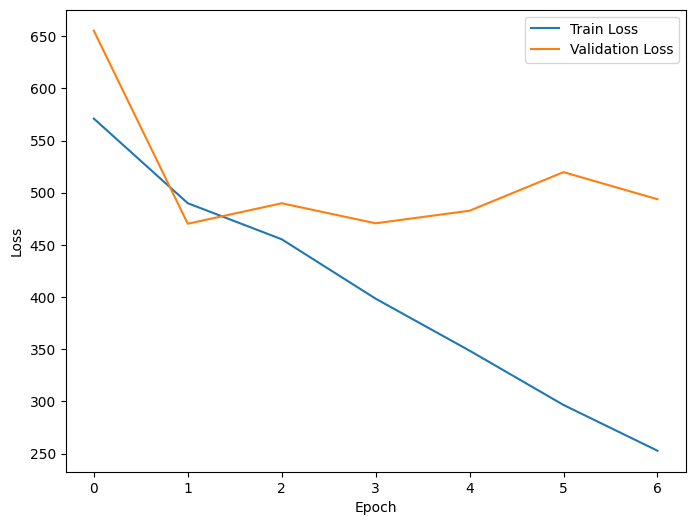

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label="Train Loss")
    plt.plot(hist['epoch'], hist['val_loss'], label="Validation Loss")
    plt.legend()
    plt.show()

# Plot the training history
plot_history(history)

In [32]:
# Evaluate model1 performance on test dataset
loss, mae = model1.evaluate(test_dataset)

print(f"Model 1 Performance on Test Set:")
print(f"Mean Squared Error (MSE): {loss:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - loss: 470.5808 - mae: 16.3156
Model 1 Performance on Test Set:
Mean Squared Error (MSE): 460.4494
Mean Absolute Error (MAE): 16.3123


In [11]:
# Predict Pawpularity scores on test set
y_pred = model1.predict(X_test).flatten()  # Flatten to 1D array for easy comparison

# Compare first 10 predictions
for i in range(10):
    print(f"Actual: {y_test[i]:.2f}, Predicted: {y_pred[i]:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step
Actual: 32.00, Predicted: 36.13
Actual: 100.00, Predicted: 27.05
Actual: 26.00, Predicted: 29.03
Actual: 48.00, Predicted: 42.80
Actual: 12.00, Predicted: 29.46
Actual: 73.00, Predicted: 47.20
Actual: 27.00, Predicted: 25.29
Actual: 33.00, Predicted: 45.19
Actual: 45.00, Predicted: 37.55
Actual: 54.00, Predicted: 33.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.7337582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].


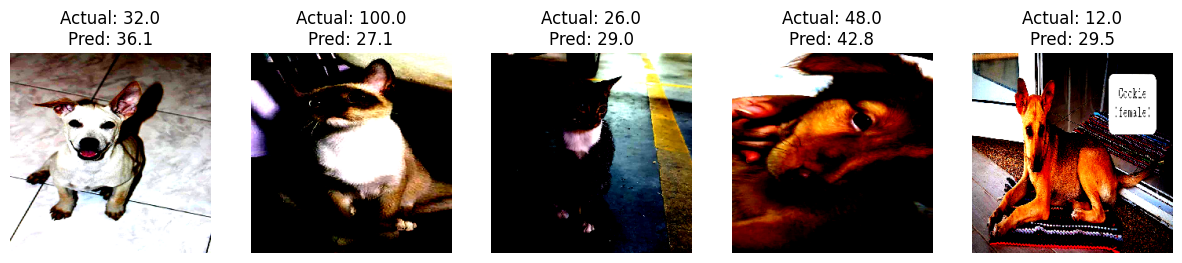

In [12]:
import matplotlib.pyplot as plt

# Show some images with actual vs predicted scores
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show test images
    ax.set_title(f"Actual: {y_test[i]:.1f}\nPred: {y_pred[i]:.1f}")
    ax.axis("off")
plt.show()

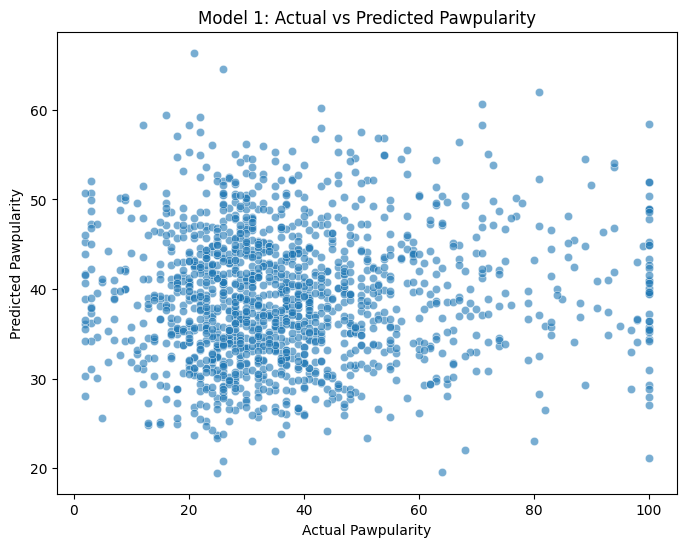

In [23]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("Model 1: Actual vs Predicted Pawpularity")
plt.show()

Observations:

	1.	High Dispersion:

	•	The predicted values are scattered widely across the y-axis for each actual value on the x-axis.
	•	This suggests that the model is struggling to capture a clear relationship between the actual and predicted “Pawpularity” scores.
	2.	No Clear Trend:

	•	In a well-performing model, we would expect points to cluster along the y = x line (diagonal).
	•	Instead, your predictions seem to be mostly centered around a specific range (e.g., 30-50), failing to capture extreme values properly.
	3.	Prediction Collapse:

	•	Many predictions appear to be compressed into a narrow range (around 30-50), regardless of the actual values.
	•	This could indicate that the model is over-regularized, lacks complexity, or isn’t effectively learning from image features.
	4.	Poor Handling of Edge Cases:

	•	The actual scores near 0 and 100 still receive mid-range predictions.
	•	This suggests your model might be biased toward predicting values close to the mean rather than distinguishing between truly popular and unpopular pets.

Possible Reasons for Poor Performance:

	1.	CNN Feature Extraction Issues:

	•	Your CNN might not be extracting meaningful features related to pet cuteness.
	•	Consider using transfer learning with a pre-trained model like ResNet, EfficientNet, or ViT (Vision Transformer).
	2.	Loss Function & Training Issues:

	•	If you are using MSE (Mean Squared Error), it might not be the best loss function. Try Huber loss or Quantile loss to reduce the effect of outliers.
	•	Check if your model is underfitting (not learning enough patterns) or overfitting (memorizing training data but failing to generalize).
	3.	Imbalanced Data Distribution:

	•	If most samples have a mid-range Pawpularity score, the model may be biased toward predicting the average rather than learning the full range.
	4.	Training Strategy:
	
	•	Try data augmentation to provide more variety in images.
	•	Experiment with different learning rates, optimizers (Adam, SGD with momentum), and batch normalization.

# Model 2


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model2
model2 = keras.Sequential()

# Input Layer
model2.add(layers.Input(shape=(256, 256, 3)))  # Keep 256x256 image size

# First Convolutional Block
model2.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model2.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model2.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Fouth Convolutional Block
model2.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.4))  # Prevent overfitting
model2.add(layers.Dense(1, activation='linear'))  # Regression output

# Compile the model2 with Mean Squared Error (MSE) loss
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Show the model2 architecture
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,195,681 (8.38 MB)

 Trainable params: 2,195,201 (8.37 MB)

 Non-trainable params: 480 (1.88 KB)

In [15]:
import time

# Callback to display loss at each epoch
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        t = time.monotonic() - self.time
        print('| Epoch {:2} | Time {:6.2f}s | Train Loss {:.4f} | Val Loss {:.4f} |'
              .format(epoch, t, logs['loss'], logs['val_loss']))

    def on_epoch_begin(self, epoch, logs):
        if epoch == 0:
            self.time = time.monotonic()

# Define training parameters
EPOCHS = 50
BATCH_SIZE = 32

# Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model2
history = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, PrintLoss()]
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - loss: 770.4364 - mae: 20.5536| Epoch  0 | Time  99.30s | Train Loss 640.0718 | Val Loss 480.7123 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 99s 452ms/step - loss: 769.8384 - mae: 20.5465 - val_loss: 480.7123 - val_mae: 16.2372
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - loss: 577.2681 - mae: 18.1627| Epoch  1 | Time 204.31s | Train Loss 562.2471 | Val Loss 484.2984 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 105s 484ms/step - loss: 577.1992 - mae: 18.1615 - val_loss: 484.2984 - val_mae: 17.5068
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - loss: 513.4005 - mae: 17.1161| Epoch  2 | Time 310.89s | Train Loss 512.3658 | Val Loss 468.9847 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 107s 491ms/step - loss: 513.3958 - mae: 17.1161 - val_loss: 468.9847 - val_mae: 16.7271
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - loss: 490.3916 - mae: 16.6106| Epoch  3 | Time 427.05s | Train Loss 491.2049 | Val Loss 474.4571 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 1

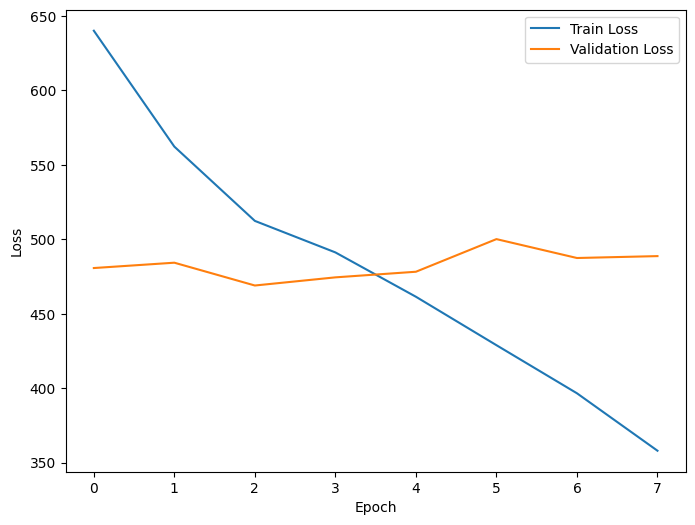

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label="Train Loss")
    plt.plot(hist['epoch'], hist['val_loss'], label="Validation Loss")
    plt.legend()
    plt.show()

# Plot the training history
plot_history(history)

In [19]:
# Evaluate model1 performance on test dataset
loss, mae = model2.evaluate(test_dataset)

print(f"Model 2 Performance on Test Set:")
print(f"Mean Squared Error (MSE): {loss:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 479.4945 - mae: 16.7495
Model 2 Performance on Test Set:
Mean Squared Error (MSE): 477.3470
Mean Absolute Error (MAE): 16.7132


In [20]:
# Predict Pawpularity scores on test set
y_pred_2= model2.predict(X_test).flatten()  # Flatten to 1D array for easy comparison

# Compare first 10 predictions
for i in range(10):
    print(f"Actual: {y_test[i]:.2f}, Predicted: {y_pred_2[i]:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step
Actual: 32.00, Predicted: 51.59
Actual: 100.00, Predicted: 40.11
Actual: 26.00, Predicted: 34.70
Actual: 48.00, Predicted: 40.14
Actual: 12.00, Predicted: 34.80
Actual: 73.00, Predicted: 37.99
Actual: 27.00, Predicted: 34.12
Actual: 33.00, Predicted: 39.71
Actual: 45.00, Predicted: 41.24
Actual: 54.00, Predicted: 42.66


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.7337582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].


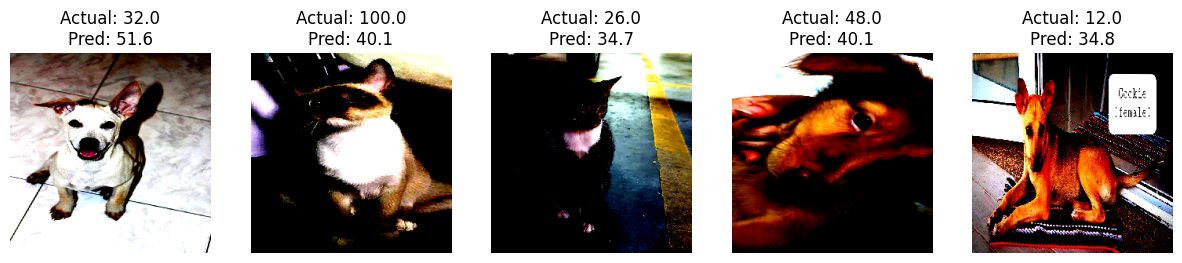

In [21]:
import matplotlib.pyplot as plt

# Show some images with actual vs predicted scores
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show test images
    ax.set_title(f"Actual: {y_test[i]:.1f}\nPred: {y_pred_2[i]:.1f}")
    ax.axis("off")
plt.show()

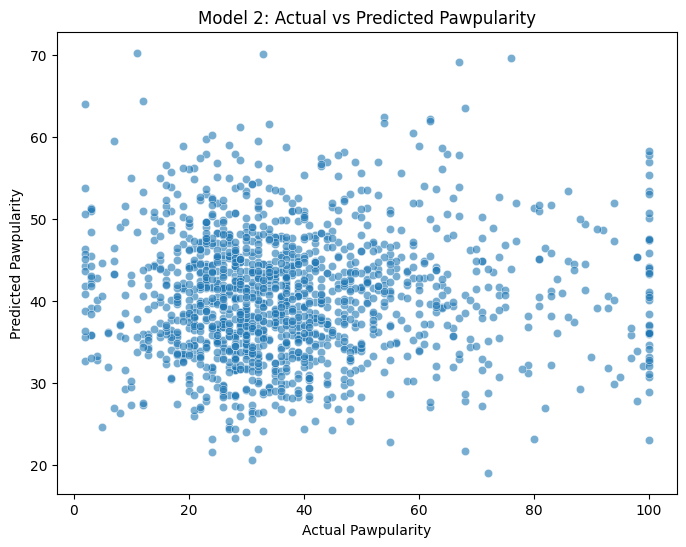

In [22]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_2, alpha=0.6)
plt.xlabel("Actual Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("Model 2: Actual vs Predicted Pawpularity")
plt.show()

# Model 3

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model3
model3 = keras.Sequential()

# Input Layer
model3.add(layers.Input(shape=(256, 256, 3)))  # Keep 256x256 image size

# First Convolutional Block
model3.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model3.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model3.add(layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Fouth Convolutional Block
model3.add(layers.Conv2D(filters=128, kernel_size=(7, 7), activation='relu', padding='same'))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(0.4))  # Prevent overfitting
model3.add(layers.Dense(1, activation='linear'))  # Regression output

# Compile the model3 with Mean Squared Error (MSE) loss
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model3.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Show the model3 architecture
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,556,129 (9.75 MB)

 Trainable params: 2,555,649 (9.75 MB)

 Non-trainable params: 480 (1.88 KB)

In [26]:
import time

# Callback to display loss at each epoch
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        t = time.monotonic() - self.time
        print('| Epoch {:2} | Time {:6.2f}s | Train Loss {:.4f} | Val Loss {:.4f} |'
              .format(epoch, t, logs['loss'], logs['val_loss']))

    def on_epoch_begin(self, epoch, logs):
        if epoch == 0:
            self.time = time.monotonic()

# Define training parameters
EPOCHS = 50
BATCH_SIZE = 32

# Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model3
history = model3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, PrintLoss()]
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - loss: 774.5439 - mae: 20.5814| Epoch  0 | Time 156.60s | Train Loss 652.8781 | Val Loss 488.6786 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 157s 717ms/step - loss: 773.9858 - mae: 20.5752 - val_loss: 488.6786 - val_mae: 16.3530
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - loss: 564.7324 - mae: 17.8153| Epoch  1 | Time 328.51s | Train Loss 561.7335 | Val Loss 545.8327 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 172s 792ms/step - loss: 564.7186 - mae: 17.8152 - val_loss: 545.8327 - val_mae: 19.2969
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - loss: 522.2097 - mae: 17.0213| Epoch  2 | Time 499.21s | Train Loss 516.4092 | Val Loss 486.8183 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 210s 969ms/step - loss: 522.1830 - mae: 17.0211 - val_loss: 486.8183 - val_mae: 17.9348
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - loss: 489.2757 - mae: 16.5388| Epoch  3 | Time 685.00s | Train Loss 487.7073 | Val Loss 437.3660 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 

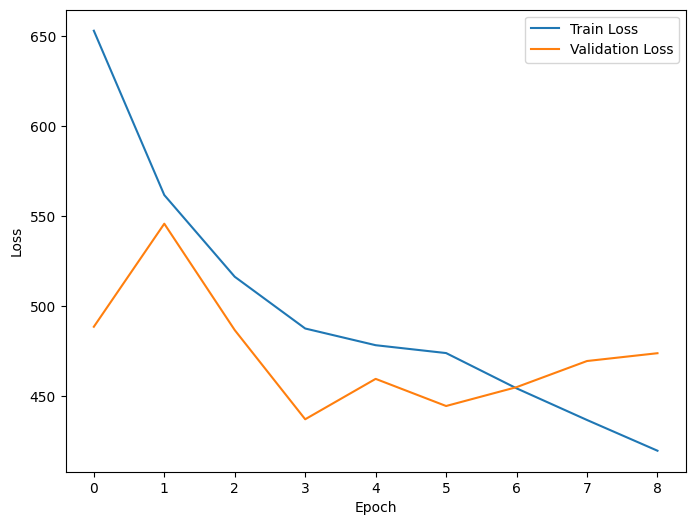

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label="Train Loss")
    plt.plot(hist['epoch'], hist['val_loss'], label="Validation Loss")
    plt.legend()
    plt.show()

# Plot the training history
plot_history(history)

In [28]:
# Evaluate model3 performance on test dataset
loss, mae = model3.evaluate(test_dataset)

print(f"Model 3 Performance on Test Set:")
print(f"Mean Squared Error (MSE): {loss:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - loss: 454.0503 - mae: 15.6592
Model 3 Performance on Test Set:
Mean Squared Error (MSE): 446.3752
Mean Absolute Error (MAE): 15.6277


In [29]:
# Predict Pawpularity scores on test set
y_pred_3= model3.predict(X_test).flatten()  # Flatten to 1D array for easy comparison

# Compare first 10 predictions
for i in range(10):
    print(f"Actual: {y_test[i]:.2f}, Predicted: {y_pred_3[i]:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step
Actual: 32.00, Predicted: 42.46
Actual: 100.00, Predicted: 41.36
Actual: 26.00, Predicted: 31.15
Actual: 48.00, Predicted: 40.25
Actual: 12.00, Predicted: 39.16
Actual: 73.00, Predicted: 37.97
Actual: 27.00, Predicted: 30.29
Actual: 33.00, Predicted: 35.16
Actual: 45.00, Predicted: 37.71
Actual: 54.00, Predicted: 38.53


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.7337582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].


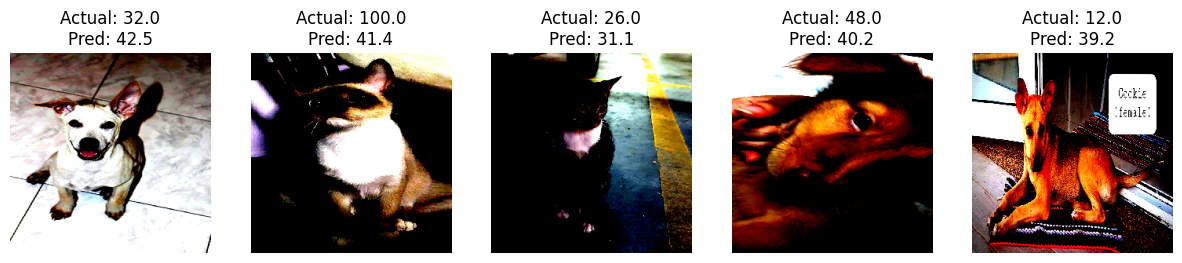

In [30]:
import matplotlib.pyplot as plt

# Show some images with actual vs predicted scores
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show test images
    ax.set_title(f"Actual: {y_test[i]:.1f}\nPred: {y_pred_3[i]:.1f}")
    ax.axis("off")
plt.show()

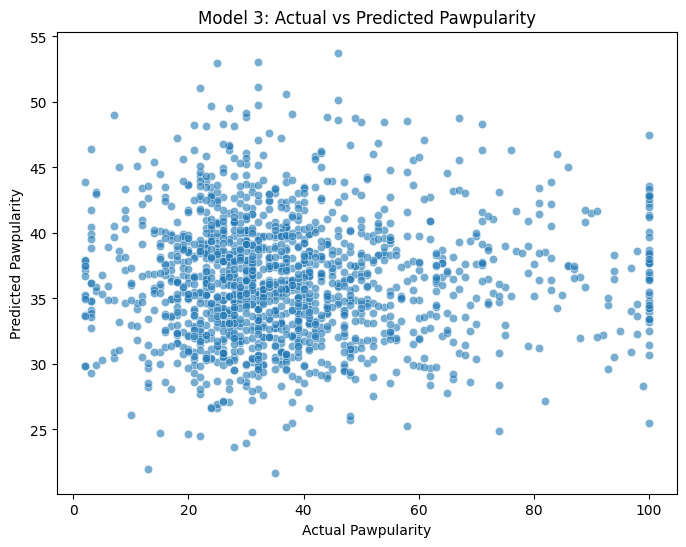

In [31]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_3, alpha=0.6)
plt.xlabel("Actual Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("Model 3: Actual vs Predicted Pawpularity")
plt.show()

Key Takeaways from Model 3 vs. Model 2 and Model 1:

	1.	More Centralized Predictions (Less Variability)
	•	Model 3 shows tighter clustering in the 30-45 range, meaning it struggles to predict extreme values.
	•	Compared to Model 2, Model 3’s predictions are slightly more compressed, suggesting that increasing kernel size in later layers blurs finer details.
	2.	Fewer Outliers but Worse Coverage
	•	Model 2 had predictions spreading beyond 70, while Model 3 mostly stays below 55.
	•	This suggests Model 3 has weaker generalization for high-Pawpularity images, possibly because larger kernels lose local texture details.
	3.	Trade-off Between Local vs. Global Features
	•	Larger kernels (5×5 and 7×7 in Model 3) increase the receptive field, helping detect broader patterns in images.
	•	However, they might cause the model to miss finer-grained details, leading to over-smoothing and poor prediction of extreme Pawpularity scores.

# Model 4

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model4
model4 = keras.Sequential()

# Input Layer
model4.add(layers.Input(shape=(256, 256, 3)))  # Keep 256x256 image size

# First Convolutional Block
model4.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model4.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model4.add(layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Fouth Convolutional Block
model4.add(layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same'))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model4.add(layers.Flatten())
model4.add(layers.Dense(128, activation='relu'))
model4.add(layers.Dropout(0.4))  # Prevent overfitting
model4.add(layers.Dense(1, activation='linear'))  # Regression output

# Compile the model4 with Mean Squared Error (MSE) loss
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model4.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Show the model4 architecture
model4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,456,801 (17.00 MB)

 Trainable params: 4,456,321 (17.00 MB)

 Non-trainable params: 480 (1.88 KB)

In [34]:
import time

# Callback to display loss at each epoch
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        t = time.monotonic() - self.time
        print('| Epoch {:2} | Time {:6.2f}s | Train Loss {:.4f} | Val Loss {:.4f} |'
              .format(epoch, t, logs['loss'], logs['val_loss']))

    def on_epoch_begin(self, epoch, logs):
        if epoch == 0:
            self.time = time.monotonic()

# Define training parameters
EPOCHS = 50
BATCH_SIZE = 32

# Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model4
history = model4.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, PrintLoss()]
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 811.6652 - mae: 21.0967| Epoch  0 | Time 138.00s | Train Loss 641.0998 | Val Loss 473.0902 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 138s 631ms/step - loss: 810.8828 - mae: 21.0871 - val_loss: 473.0902 - val_mae: 16.7244
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - loss: 529.3981 - mae: 17.2360| Epoch  1 | Time 284.27s | Train Loss 529.3050 | Val Loss 470.5540 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 146s 674ms/step - loss: 529.3977 - mae: 17.2365 - val_loss: 470.5540 - val_mae: 15.5187
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 485.1866 - mae: 16.5703| Epoch  2 | Time 422.12s | Train Loss 480.3838 | Val Loss 523.6113 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - loss: 485.1646 - mae: 16.5698 - val_loss: 523.6113 - val_mae: 16.5514
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - loss: 474.0445 - mae: 16.3692| Epoch  3 | Time 569.46s | Train Loss 467.3917 | Val Loss 445.1572 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 147s 6

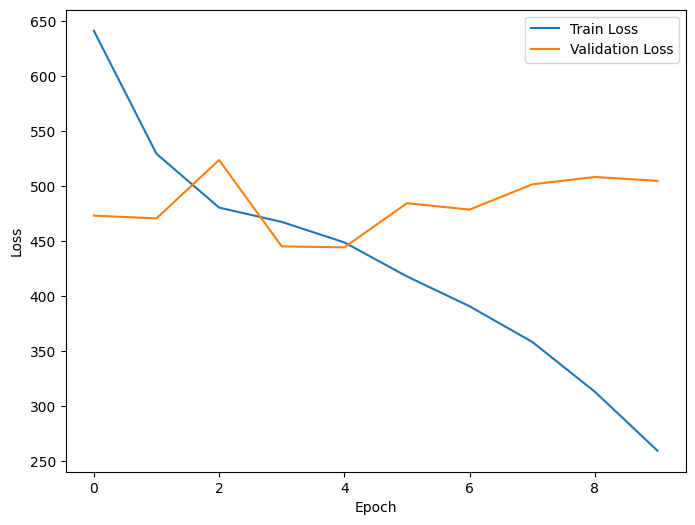

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label="Train Loss")
    plt.plot(hist['epoch'], hist['val_loss'], label="Validation Loss")
    plt.legend()
    plt.show()

# Plot the training history
plot_history(history)

In [37]:
# Evaluate model4 performance on test dataset
loss, mae = model4.evaluate(test_dataset)

print(f"Model 4 Performance on Test Set:")
print(f"Mean Squared Error (MSE): {loss:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 479.4950 - mae: 16.1555
Model 4 Performance on Test Set:
Mean Squared Error (MSE): 463.8576
Mean Absolute Error (MAE): 16.0849


In [38]:
# Predict Pawpularity scores on test set
y_pred_4= model4.predict(X_test).flatten()  # Flatten to 1D array for easy comparison

# Compare first 10 predictions
for i in range(10):
    print(f"Actual: {y_test[i]:.2f}, Predicted: {y_pred_4[i]:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step
Actual: 32.00, Predicted: 30.96
Actual: 100.00, Predicted: 42.12
Actual: 26.00, Predicted: 31.18
Actual: 48.00, Predicted: 47.50
Actual: 12.00, Predicted: 36.16
Actual: 73.00, Predicted: 42.98
Actual: 27.00, Predicted: 27.60
Actual: 33.00, Predicted: 30.50
Actual: 45.00, Predicted: 47.41
Actual: 54.00, Predicted: 36.28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.7337582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].


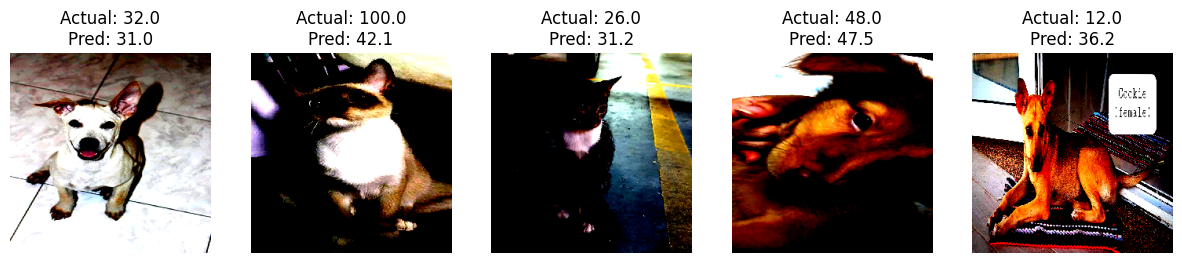

In [39]:
import matplotlib.pyplot as plt

# Show some images with actual vs predicted scores
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show test images
    ax.set_title(f"Actual: {y_test[i]:.1f}\nPred: {y_pred_4[i]:.1f}")
    ax.axis("off")
plt.show()

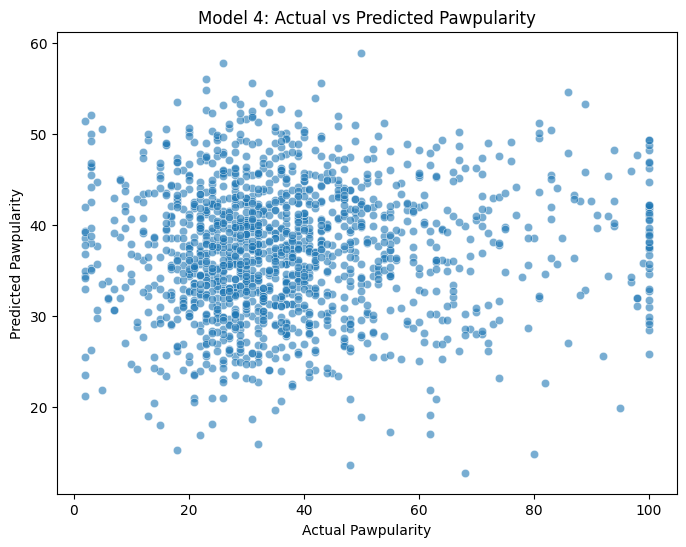

In [40]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_4, alpha=0.6)
plt.xlabel("Actual Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("Model 4: Actual vs Predicted Pawpularity")
plt.show()

# Model 5

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model5
model5 = keras.Sequential()

# Input Layer
model5.add(layers.Input(shape=(256, 256, 3)))  # Keep 256x256 image size

# First Convolutional Block
model5.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model5.add(layers.BatchNormalization())
model5.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model5.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model5.add(layers.BatchNormalization())
model5.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model5.add(layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
model5.add(layers.BatchNormalization())
model5.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Fouth Convolutional Block
model5.add(layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same'))
model5.add(layers.BatchNormalization())
model5.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model5.add(layers.Flatten())
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dropout(0.4))  # Prevent overfitting
model5.add(layers.Dense(1, activation='linear'))  # Regression output

# Compile the model5 with Mean Squared Error (MSE) loss
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model5.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Show the model5 architecture
model5.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,359,521 (9.00 MB)

 Trainable params: 2,359,041 (9.00 MB)

 Non-trainable params: 480 (1.88 KB)

In [45]:
import time

# Callback to display loss at each epoch
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        t = time.monotonic() - self.time
        print('| Epoch {:2} | Time {:6.2f}s | Train Loss {:.4f} | Val Loss {:.4f} |'
              .format(epoch, t, logs['loss'], logs['val_loss']))

    def on_epoch_begin(self, epoch, logs):
        if epoch == 0:
            self.time = time.monotonic()

# Define training parameters
EPOCHS = 50
BATCH_SIZE = 32

# Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model5
history = model5.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, PrintLoss()]
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - loss: 5652.4771 - mae: 37.1357| Epoch  0 | Time 163.35s | Train Loss 1863.3077 | Val Loss 516.0675 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 163s 748ms/step - loss: 5635.0957 - mae: 37.0800 - val_loss: 516.0675 - val_mae: 16.1889
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - loss: 679.6791 - mae: 19.6440| Epoch  1 | Time 332.99s | Train Loss 678.1021 | Val Loss 517.5831 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 170s 782ms/step - loss: 679.6718 - mae: 19.6444 - val_loss: 517.5831 - val_mae: 16.3635
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - loss: 664.5499 - mae: 19.4720| Epoch  2 | Time 505.13s | Train Loss 673.9447 | Val Loss 635.6442 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 172s 793ms/step - loss: 664.5930 - mae: 19.4726 - val_loss: 635.6442 - val_mae: 20.0167
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - loss: 669.7101 - mae: 19.5495| Epoch  3 | Time 687.74s | Train Loss 664.4927 | Val Loss 553.6882 |
217/217 ━━━━━━━━━━━━━━━━━━

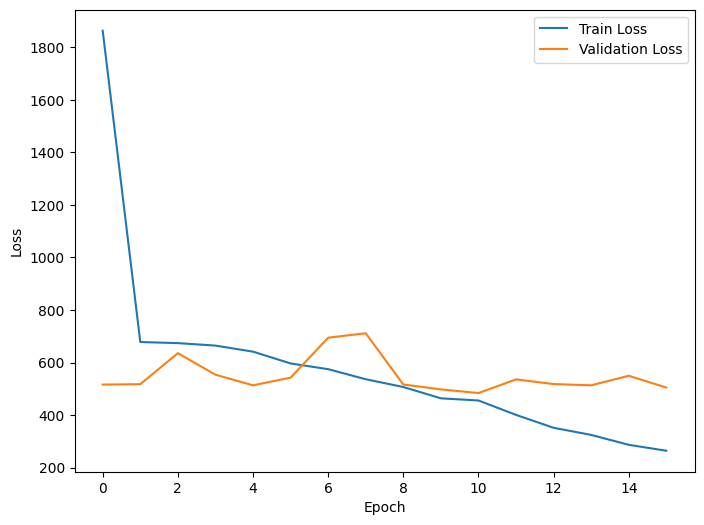

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label="Train Loss")
    plt.plot(hist['epoch'], hist['val_loss'], label="Validation Loss")
    plt.legend()
    plt.show()

# Plot the training history
plot_history(history)

In [51]:
# Evaluate model5 performance on test dataset
loss, mae = model5.evaluate(test_dataset)

print(f"Model 5 Performance on Test Set:")
print(f"Mean Squared Error (MSE): {loss:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: 514.8422 - mae: 16.5282
Model 5 Performance on Test Set:
Mean Squared Error (MSE): 504.1363
Mean Absolute Error (MAE): 16.4943


In [48]:
# Predict Pawpularity scores on test set
y_pred_5= model5.predict(X_test).flatten()  # Flatten to 1D array for easy comparison

# Compare first 10 predictions
for i in range(10):
    print(f"Actual: {y_test[i]:.2f}, Predicted: {y_pred_5[i]:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step
Actual: 32.00, Predicted: 42.28
Actual: 100.00, Predicted: 31.86
Actual: 26.00, Predicted: 27.86
Actual: 48.00, Predicted: 35.75
Actual: 12.00, Predicted: 29.60
Actual: 73.00, Predicted: 34.33
Actual: 27.00, Predicted: 38.13
Actual: 33.00, Predicted: 33.88
Actual: 45.00, Predicted: 34.97
Actual: 54.00, Predicted: 37.91


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.7337582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].


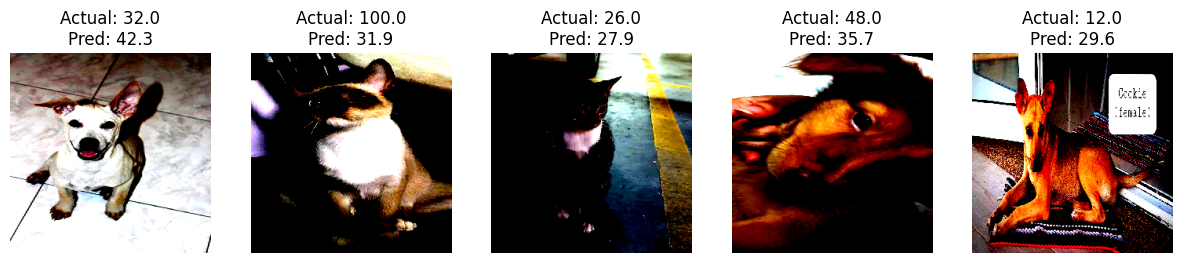

In [49]:
import matplotlib.pyplot as plt

# Show some images with actual vs predicted scores
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show test images
    ax.set_title(f"Actual: {y_test[i]:.1f}\nPred: {y_pred_5[i]:.1f}")
    ax.axis("off")
plt.show()

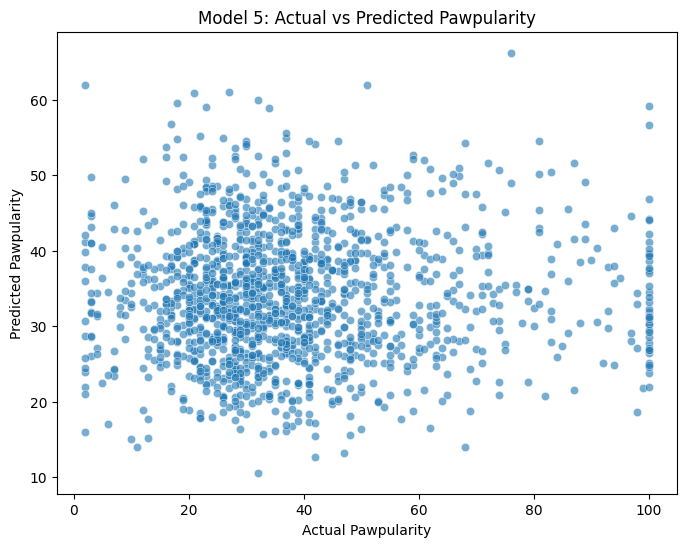

In [50]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_5, alpha=0.6)
plt.xlabel("Actual Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("Model 5: Actual vs Predicted Pawpularity")
plt.show()

# Model 6

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model6
model6 = keras.Sequential()

# Input Layer
model6.add(layers.Input(shape=(256, 256, 3)))  # Keep 256x256 image size

# First Convolutional Block
model6.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model6.add(layers.BatchNormalization())
model6.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model6.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model6.add(layers.BatchNormalization())
model6.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model6.add(layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
model6.add(layers.BatchNormalization())
model6.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Fouth Convolutional Block
model6.add(layers.Conv2D(filters=128, kernel_size=(7, 7), activation='relu', padding='same'))
model6.add(layers.BatchNormalization())
model6.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model6.add(layers.Flatten())
model6.add(layers.Dense(64, activation='relu'))
model6.add(layers.Dropout(0.5))  # Prevent overfitting
model6.add(layers.Dense(1, activation='linear'))  # Regression output

# Compile the model6 with Mean Squared Error (MSE) loss
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model6.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Show the model6 architecture
model6.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,556,129 (9.75 MB)

 Trainable params: 2,555,649 (9.75 MB)

 Non-trainable params: 480 (1.88 KB)

In [53]:
import time

# Callback to display loss at each epoch
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        t = time.monotonic() - self.time
        print('| Epoch {:2} | Time {:6.2f}s | Train Loss {:.4f} | Val Loss {:.4f} |'
              .format(epoch, t, logs['loss'], logs['val_loss']))

    def on_epoch_begin(self, epoch, logs):
        if epoch == 0:
            self.time = time.monotonic()

# Define training parameters
EPOCHS = 50
BATCH_SIZE = 32

# Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model6
history = model6.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, PrintLoss()]
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - loss: 852.9606 - mae: 21.7057| Epoch  0 | Time 164.01s | Train Loss 712.4333 | Val Loss 558.7644 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 164s 750ms/step - loss: 852.3160 - mae: 21.6984 - val_loss: 558.7644 - val_mae: 19.1548
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - loss: 596.7804 - mae: 18.3225| Epoch  1 | Time 357.48s | Train Loss 604.3743 | Val Loss 796.0307 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 193s 891ms/step - loss: 596.8152 - mae: 18.3232 - val_loss: 796.0307 - val_mae: 22.5157
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - loss: 574.9226 - mae: 17.9476| Epoch  2 | Time 559.77s | Train Loss 553.1849 | Val Loss 485.6894 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 202s 932ms/step - loss: 574.8229 - mae: 17.9462 - val_loss: 485.6894 - val_mae: 17.1466
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 511.0162 - mae: 16.9693| Epoch  3 | Time 738.15s | Train Loss 513.7117 | Val Loss 456.6031 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 256

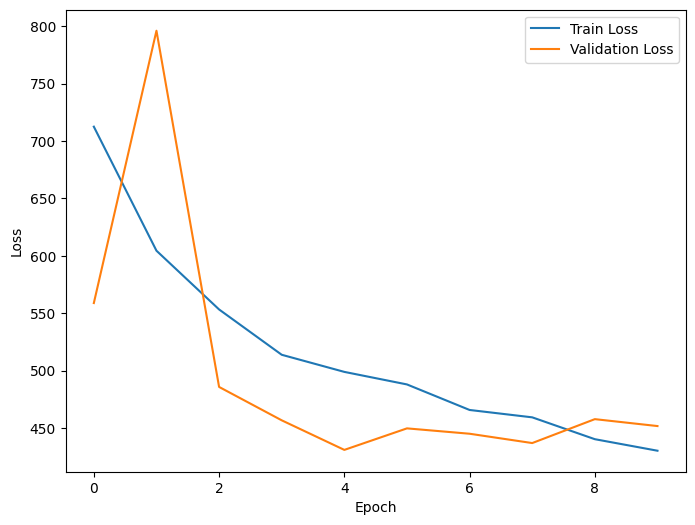

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label="Train Loss")
    plt.plot(hist['epoch'], hist['val_loss'], label="Validation Loss")
    plt.legend()
    plt.show()

# Plot the training history
plot_history(history)

In [55]:
# Evaluate model6 performance on test dataset
loss, mae = model6.evaluate(test_dataset)

print(f"Model 6 Performance on Test Set:")
print(f"Mean Squared Error (MSE): {loss:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - loss: 448.8453 - mae: 15.6907
Model 6 Performance on Test Set:
Mean Squared Error (MSE): 433.4158
Mean Absolute Error (MAE): 15.6164


In [56]:
# Predict Pawpularity scores on test set
y_pred_6= model6.predict(X_test).flatten()  # Flatten to 1D array for easy comparison

# Compare first 10 predictions
for i in range(10):
    print(f"Actual: {y_test[i]:.2f}, Predicted: {y_pred_6[i]:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step
Actual: 32.00, Predicted: 38.94
Actual: 100.00, Predicted: 39.49
Actual: 26.00, Predicted: 27.11
Actual: 48.00, Predicted: 37.00
Actual: 12.00, Predicted: 38.95
Actual: 73.00, Predicted: 34.55
Actual: 27.00, Predicted: 40.06
Actual: 33.00, Predicted: 40.74
Actual: 45.00, Predicted: 45.58
Actual: 54.00, Predicted: 35.52


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.7337582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].


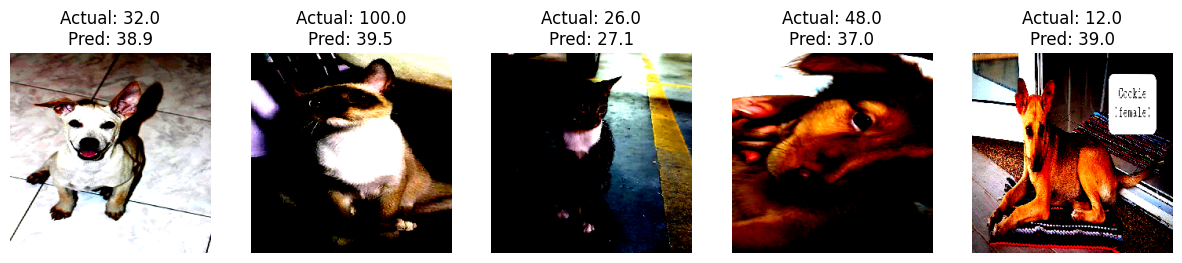

In [57]:
import matplotlib.pyplot as plt

# Show some images with actual vs predicted scores
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show test images
    ax.set_title(f"Actual: {y_test[i]:.1f}\nPred: {y_pred_6[i]:.1f}")
    ax.axis("off")
plt.show()

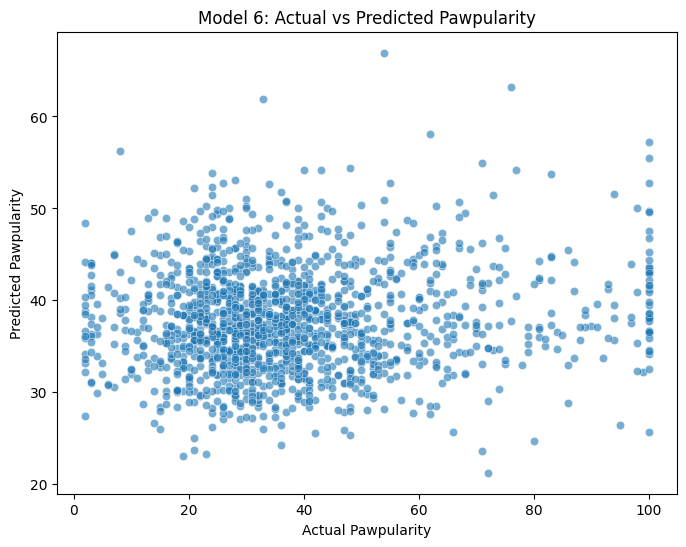

In [58]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_6, alpha=0.6)
plt.xlabel("Actual Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("Model 6: Actual vs Predicted Pawpularity")
plt.show()

# Model 7

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model7
model7 = keras.Sequential()

# Input Layer
model7.add(layers.Input(shape=(256, 256, 3)))  # Keep 256x256 image size

# First Convolutional Block
model7.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model7.add(layers.BatchNormalization())
model7.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model7.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model7.add(layers.BatchNormalization())
model7.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model7.add(layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
model7.add(layers.BatchNormalization())
model7.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Fouth Convolutional Block
model7.add(layers.Conv2D(filters=128, kernel_size=(7, 7), activation='relu', padding='same'))
model7.add(layers.BatchNormalization())
model7.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model7.add(layers.Flatten())
model7.add(layers.Dense(64, activation='relu'))
model7.add(layers.Dropout(0.6))  # Prevent overfitting
model7.add(layers.Dense(1, activation='linear'))  # Regression output

# Compile the model7 with Mean Squared Error (MSE) loss
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model7.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Show the model7 architecture
model7.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 32, 32, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,556,129 (9.75 MB)

 Trainable params: 2,555,649 (9.75 MB)

 Non-trainable params: 480 (1.88 KB)

In [60]:
import time

# Callback to display loss at each epoch
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        t = time.monotonic() - self.time
        print('| Epoch {:2} | Time {:6.2f}s | Train Loss {:.4f} | Val Loss {:.4f} |'
              .format(epoch, t, logs['loss'], logs['val_loss']))

    def on_epoch_begin(self, epoch, logs):
        if epoch == 0:
            self.time = time.monotonic()

# Define training parameters
EPOCHS = 50
BATCH_SIZE = 32

# Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model7
history = model7.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, PrintLoss()]
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - loss: 786.8369 - mae: 21.3092| Epoch  0 | Time 161.68s | Train Loss 711.5330 | Val Loss 457.6650 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 162s 740ms/step - loss: 786.4914 - mae: 21.3042 - val_loss: 457.6650 - val_mae: 16.2470
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - loss: 619.5275 - mae: 18.7808| Epoch  1 | Time 364.97s | Train Loss 617.4487 | Val Loss 453.5290 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 203s 937ms/step - loss: 619.5179 - mae: 18.7805 - val_loss: 453.5290 - val_mae: 16.1410
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - loss: 577.8618 - mae: 17.9779| Epoch  2 | Time 571.75s | Train Loss 567.4886 | Val Loss 466.8687 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 207s 953ms/step - loss: 577.8142 - mae: 17.9772 - val_loss: 466.8687 - val_mae: 15.0162
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - loss: 563.8887 - mae: 17.7520| Epoch  3 | Time 782.42s | Train Loss 565.6456 | Val Loss 508.7939 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 

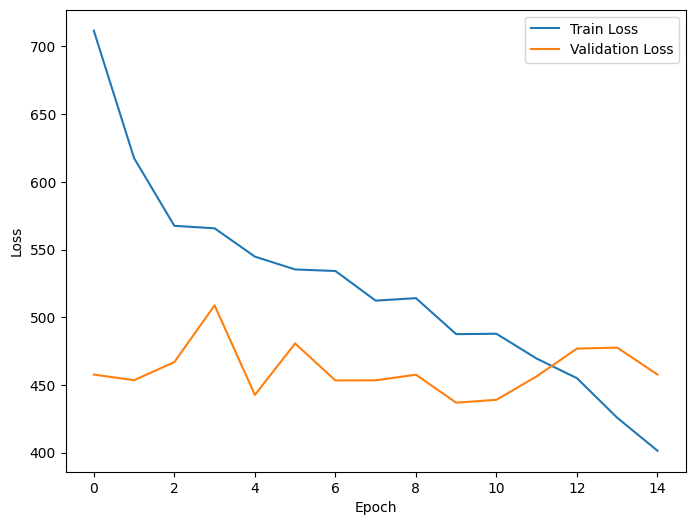

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label="Train Loss")
    plt.plot(hist['epoch'], hist['val_loss'], label="Validation Loss")
    plt.legend()
    plt.show()

# Plot the training history
plot_history(history)

In [62]:
# Evaluate model7 performance on test dataset
loss, mae = model7.evaluate(test_dataset)

print(f"Model 7 Performance on Test Set:")
print(f"Mean Squared Error (MSE): {loss:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - loss: 470.7755 - mae: 15.5252
Model 7 Performance on Test Set:
Mean Squared Error (MSE): 457.7807
Mean Absolute Error (MAE): 15.4302


In [63]:
# Predict Pawpularity scores on test set
y_pred_7= model7.predict(X_test).flatten()  # Flatten to 1D array for easy comparison

# Compare first 10 predictions
for i in range(10):
    print(f"Actual: {y_test[i]:.2f}, Predicted: {y_pred_7[i]:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step
Actual: 32.00, Predicted: 34.36
Actual: 100.00, Predicted: 40.07
Actual: 26.00, Predicted: 31.09
Actual: 48.00, Predicted: 42.62
Actual: 12.00, Predicted: 33.64
Actual: 73.00, Predicted: 37.16
Actual: 27.00, Predicted: 30.41
Actual: 33.00, Predicted: 37.97
Actual: 45.00, Predicted: 38.09
Actual: 54.00, Predicted: 35.17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.7337582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].


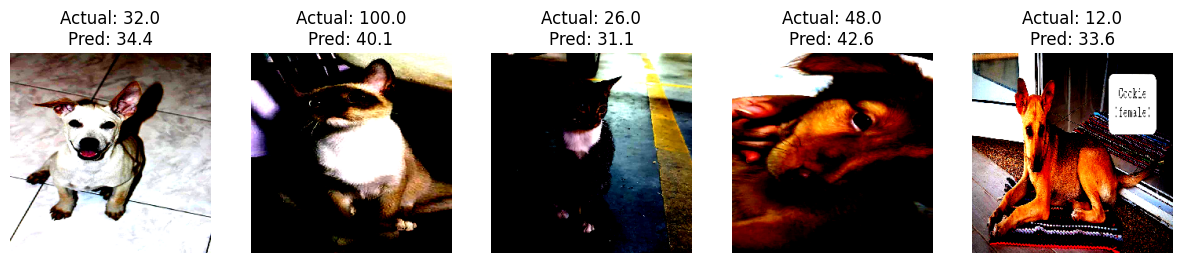

In [64]:
import matplotlib.pyplot as plt

# Show some images with actual vs predicted scores
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show test images
    ax.set_title(f"Actual: {y_test[i]:.1f}\nPred: {y_pred_7[i]:.1f}")
    ax.axis("off")
plt.show()

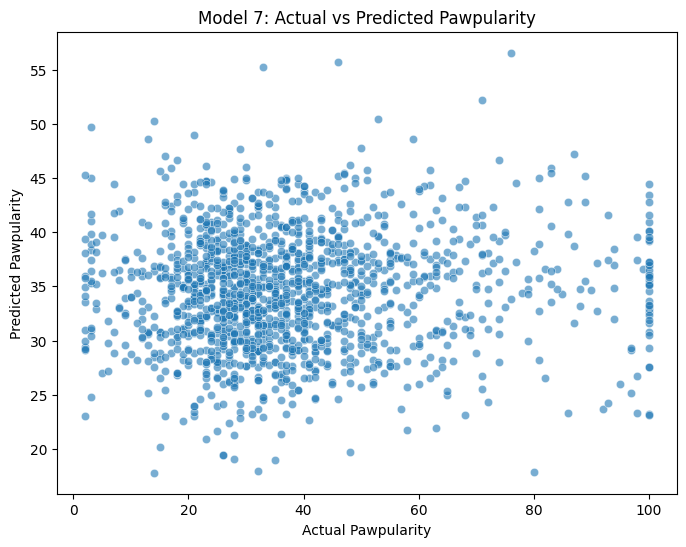

In [65]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_7, alpha=0.6)
plt.xlabel("Actual Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("Model 7: Actual vs Predicted Pawpularity")
plt.show()

# Model 8: Data Augmentation

In [66]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define Data Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
    layers.RandomRotation(0.1),  # Rotate images by up to 10%
    layers.RandomZoom(0.1),  # Random zoom to simulate different perspectives
    layers.RandomBrightness(0.1),  # Adjust brightness randomly
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1)  # Randomly shift images
])

# Define the CNN Model 8 (Improved Model 6 with Data Augmentation)
model8 = keras.Sequential()

# Input Layer with Data Augmentation
model8.add(layers.Input(shape=(256, 256, 3)))
model8.add(data_augmentation)  # Apply data augmentation

# First Convolutional Block
model8.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model8.add(layers.BatchNormalization())
model8.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model8.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model8.add(layers.BatchNormalization())
model8.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model8.add(layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
model8.add(layers.BatchNormalization())
model8.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block
model8.add(layers.Conv2D(filters=128, kernel_size=(7, 7), activation='relu', padding='same'))
model8.add(layers.BatchNormalization())
model8.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model8.add(layers.Flatten())
model8.add(layers.Dense(64, activation='relu'))
model8.add(layers.Dropout(0.5))  # Prevent overfitting
model8.add(layers.Dense(1, activation='linear'))  # Regression output

# Compile the model with Mean Squared Error (MSE) loss
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model8.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Show the updated model architecture
model8.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 32, 32, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,556,129 (9.75 MB)

 Trainable params: 2,555,649 (9.75 MB)

 Non-trainable params: 480 (1.88 KB)

In [67]:
import time

# Callback to display loss at each epoch
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        t = time.monotonic() - self.time
        print('| Epoch {:2} | Time {:6.2f}s | Train Loss {:.4f} | Val Loss {:.4f} |'
              .format(epoch, t, logs['loss'], logs['val_loss']))

    def on_epoch_begin(self, epoch, logs):
        if epoch == 0:
            self.time = time.monotonic()

# Define training parameters
EPOCHS = 50
BATCH_SIZE = 32

# Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model8.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, PrintLoss()]
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - loss: 780.6880 - mae: 20.7020| Epoch  0 | Time 167.51s | Train Loss 639.8351 | Val Loss 496.3581 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 167s 766ms/step - loss: 780.0420 - mae: 20.6936 - val_loss: 496.3581 - val_mae: 15.3561
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - loss: 566.0015 - mae: 17.7145| Epoch  1 | Time 339.69s | Train Loss 564.1054 | Val Loss 715.7087 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 172s 793ms/step - loss: 565.9928 - mae: 17.7147 - val_loss: 715.7087 - val_mae: 19.2230
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - loss: 528.1255 - mae: 17.1712| Epoch  2 | Time 536.95s | Train Loss 536.0025 | Val Loss 4449.1470 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 197s 909ms/step - loss: 528.1617 - mae: 17.1717 - val_loss: 4449.1470 - val_mae: 57.9432
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - loss: 545.0886 - mae: 17.4190| Epoch  3 | Time 749.18s | Train Loss 538.3901 | Val Loss 566.6661 |
217/217 ━━━━━━━━━━━━━━━━━━━

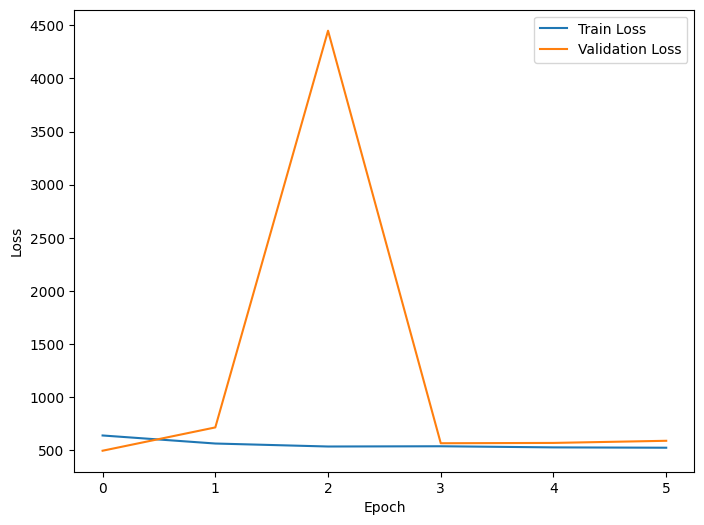

In [68]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label="Train Loss")
    plt.plot(hist['epoch'], hist['val_loss'], label="Validation Loss")
    plt.legend()
    plt.show()

# Plot the training history
plot_history(history)

In [69]:
# Evaluate model8 performance on test dataset
loss, mae = model8.evaluate(test_dataset)

print(f"Model 8 Performance on Test Set:")
print(f"Mean Squared Error (MSE): {loss:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - loss: 526.0328 - mae: 16.1176
Model 8 Performance on Test Set:
Mean Squared Error (MSE): 520.1036
Mean Absolute Error (MAE): 16.1228


In [70]:
# Predict Pawpularity scores on test set
y_pred_8= model8.predict(X_test).flatten()  # Flatten to 1D array for easy comparison

# Compare first 10 predictions
for i in range(10):
    print(f"Actual: {y_test[i]:.2f}, Predicted: {y_pred_8[i]:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step
Actual: 32.00, Predicted: 35.41
Actual: 100.00, Predicted: 25.83
Actual: 26.00, Predicted: 25.95
Actual: 48.00, Predicted: 33.48
Actual: 12.00, Predicted: 24.76
Actual: 73.00, Predicted: 30.91
Actual: 27.00, Predicted: 30.78
Actual: 33.00, Predicted: 19.70
Actual: 45.00, Predicted: 30.79
Actual: 54.00, Predicted: 35.84


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.7337582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7968014..1.9234164].


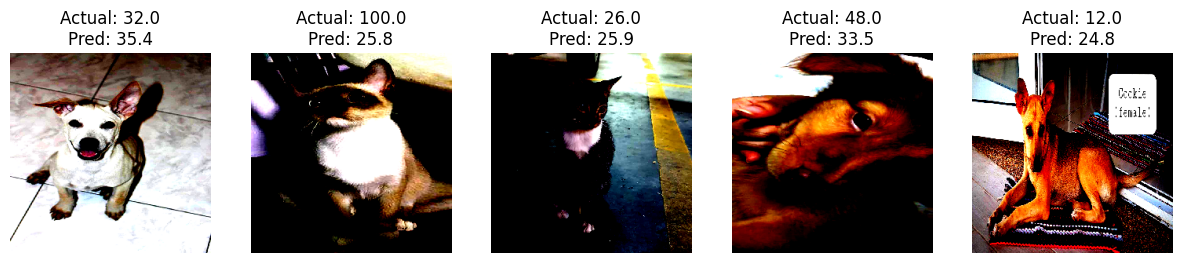

In [71]:
import matplotlib.pyplot as plt

# Show some images with actual vs predicted scores
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show test images
    ax.set_title(f"Actual: {y_test[i]:.1f}\nPred: {y_pred_8[i]:.1f}")
    ax.axis("off")
plt.show()

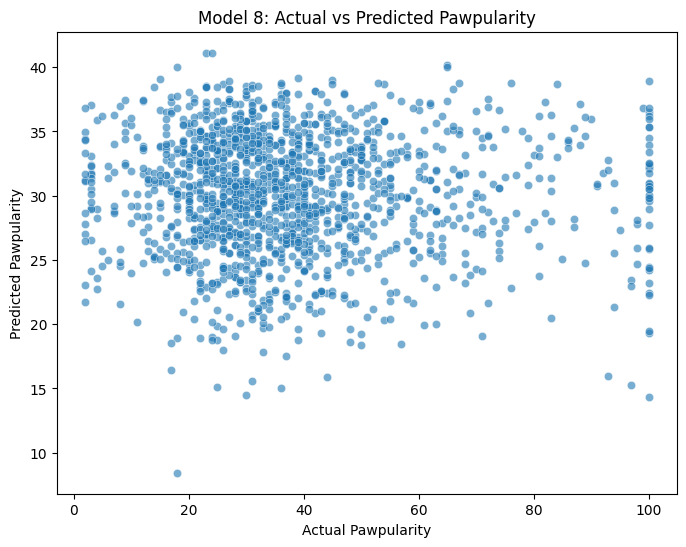

In [72]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_8, alpha=0.6)
plt.xlabel("Actual Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("Model 8: Actual vs Predicted Pawpularity")
plt.show()